## Binary Classification using Machine Learning

### Problem
1. We would like to predict given a patient, is they have COVID-19?
2. Dataset: corona.csv
     - if Corona == 1, then the person is positive for COVID, else no.

### Preliminary questions
- Which component needs improving?
- What prior knowledge the agent has, which influences the model it builds?
- What data and feedback on the data is available?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Step 0: Load the data

In [2]:
corona_df = pd.read_csv('./corona.csv',low_memory=False) #this low memory tage gets rid of a warning message that we will deal with later.
corona_df.head()

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed


#### Questions:
- What is the size of the data?
- How to load a dataset that has non-numbers?
- What are the features (predictors and target variable) in my data?

In [3]:
# We want to know the size of the data because we want to know what model to use.
# too few data points for a square data model. We want to makre sure we have enough data to focus on the data she was saying
# that a 100 by 100 data sheet is not enough.
# Therefore we need to reduce the data size or the demention.

# since we have 569 rows we would look out for a simple model.
corona_df.shape

(278848, 11)

### Step 1: Preview the first 5 rows

In [4]:
# if we try to make the model too complex it will memorize and not be able to generalize.
# She gave the example of 2 or 3 example to generalize instead of memorizing.
# if the concept is simple enough you dont need many examples
# however, the more complex the more examples needed.
corona_df.head()

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed


In [5]:
# too many missing datapoints: what should we do give these missing values.
# in the case of just a few: just drop them
# In the case of lots of data missing from the same column: we might want to drop columns.

# in one we drop rows. In the other we drop columns
# if we cannot afford dropping columns then we have to feel out those missing values.
    # This is where we would have to use the mean of the other data points (average).

#The following function tells us the number of missing values:
corona_df.isna().sum()

Ind_ID                      0
Test_date                   0
Cough_symptoms            252
Fever                     252
Sore_throat                 1
Shortness_of_breath         1
Headache                    1
Corona                      0
Age_60_above           127320
Sex                     19563
Known_contact               0
dtype: int64

#### Questions:
- Are there any missing data? If so, how to handle them?
How we will be handling the data depends on the severity of the missing data. In the case about with sore throat, shortness of breath, and headache. We can just delete those rows of data. But for the other values we need to make a potentially different decision:
Given that we have 278,848 rows of data, I think it is safe to say that just about half of my Age 60 above data is empty. This means we should likelt just remove the column all together. For sex we should just run the mean by it

#look at above.

### Step 2: Prepare the output

#### First thing we should do is determine what columns we can drop from our data.
- For empty row in Sore_throat, Shortness_of_breath, and Headache we are going to just drop the row. 
This is because it will not impact the overall impact of this data is near to none.

In [6]:
corona_df.dropna(subset = ['Sore_throat'], inplace=True)
corona_df.dropna(subset = ['Shortness_of_breath'], inplace=True)
corona_df.dropna(subset = ['Headache'], inplace=True)
corona_df.isna().sum()

Ind_ID                      0
Test_date                   0
Cough_symptoms            251
Fever                     251
Sore_throat                 0
Shortness_of_breath         0
Headache                    0
Corona                      0
Age_60_above           127319
Sex                     19562
Known_contact               0
dtype: int64

- Now what can we do with Age and Sex?
    - In the case of Sex I think we can drop the column of it all together since it should not play a role in determining if a person has COVID or not.
    - In the case of Age, however, since we are missing close to half of the data it is not going to be a usful metric for determining tests positive or negative. Therefore, for this one we will also just drop it.
    - Also we are removing ID and Date feilds from the data since our machine learning model does not need those.

In [7]:
corona_df.drop(['Age_60_above'], axis = 'columns', inplace=True)
corona_df.drop(['Sex'], axis = 'columns', inplace=True)
corona_df.drop(['Ind_ID'], axis=1, inplace=True)
corona_df.drop(['Test_date'], axis=1, inplace=True)
corona_df.isna().sum()

Cough_symptoms         251
Fever                  251
Sore_throat              0
Shortness_of_breath      0
Headache                 0
Corona                   0
Known_contact            0
dtype: int64

#### Second we should convert the data in the columns to another form for ease of calculation
- We can accomplish this for all columns and rows by examining their unique inputs (Note, nan or empty inputs will be delt with later).

In [8]:
corona_df['Cough_symptoms'].unique()

array([True, False, nan], dtype=object)

In [9]:
corona_df['Fever'].unique()

array([False, True, nan], dtype=object)

In [10]:
corona_df['Sore_throat'].unique()

array([True, False], dtype=object)

In [11]:
corona_df['Shortness_of_breath'].unique()

array([False, True], dtype=object)

In [12]:
corona_df['Headache'].unique()

array([False, True], dtype=object)

In [13]:
corona_df['Corona'].unique()

array(['negative', 'positive', 'other'], dtype=object)

In [14]:
corona_df['Known_contact'].unique()

array(['Abroad', 'Contact with confirmed', 'Other'], dtype=object)

- Based on the given information above we can clean up the data by changing all true and false to 1 and 0.
  - However, we will hold off on changing Fever and Cough_symptoms so not to overwrite the null data.
  - We are also changing positive and negative to 1 and 0.
  - Since we want to be cautious, if a test is 'other' (not positive or negative) we will treat it as positive. This will help to prevent further spread in the case of false negative since this would be more harmful.
  - For Known_contact, we are most intereseted in those who have covid and people who have been Abroad due to their greater likelihood of exposure. This means that we will be making those both 1 while making other 0.

In [15]:
corona_df['Sore_throat'] = corona_df['Sore_throat'].astype(bool).astype(int)
corona_df['Shortness_of_breath'] = corona_df['Shortness_of_breath'].astype(bool).astype(int)
corona_df['Headache'] = corona_df['Headache'].astype(bool).astype(int)
corona_df['Corona'] = corona_df['Corona'].replace({'negative': 0,'other':0, 'positive': 1})
corona_df['Known_contact'] = corona_df['Known_contact'].replace({'Abroad': 1,'Other': 0, 'Contact with confirmed': 1})
corona_df.head()

,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Known_contact
0,True,False,1,0,0,0,1
1,False,True,0,0,0,1,1
2,False,True,0,0,0,1,1
3,True,False,0,0,0,0,1
4,True,False,0,0,0,0,1


#### Third let's decide what to do with the rest of the Null rows and columns
- That is Fever and Cough_symptoms.

In [16]:
corona_df.isna().sum()

Cough_symptoms         251
Fever                  251
Sore_throat              0
Shortness_of_breath      0
Headache                 0
Corona                   0
Known_contact            0
dtype: int64

- Now for the two culumns that are missing 251 values. These numbers are larger than those of the rows we dropped. In this case we do not want to drop these points despite these rows only representing 251/278,848 or 0.0009% of the data. It would be better to just fill the empty data with the average of that data.

In [17]:
corona_df['Cough_symptoms'].fillna(value=corona_df['Cough_symptoms'].mean(), inplace=True)
corona_df.isna().sum()

Cough_symptoms           0
Fever                  251
Sore_throat              0
Shortness_of_breath      0
Headache                 0
Corona                   0
Known_contact            0
dtype: int64

- Also we can do the same with Fever column data.

In [18]:
corona_df['Fever'].fillna(value=corona_df['Fever'].mean(), inplace=True)
corona_df.isna().sum()

Cough_symptoms         0
Fever                  0
Sore_throat            0
Shortness_of_breath    0
Headache               0
Corona                 0
Known_contact          0
dtype: int64

- Now we finish our second step with converting True and False to 1 and 0.

In [19]:
corona_df['Cough_symptoms'] = corona_df['Cough_symptoms'].astype(bool).astype(int)
corona_df['Fever'] = corona_df['Fever'].astype(bool).astype(int)

In [20]:
corona_df['Corona'].describe()
# we need to make sure we are not seeing too many of one type of result because it will give it a bias towards
# that particular outcome (like in the case of positive outcome)

# another reason is that 

# we will talke about unbalanced data in future videos

count    278847.000000
mean          0.052817
std           0.223669
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Corona, dtype: float64

In [21]:
corona_df['Cough_symptoms'].describe()

count    278847.000000
mean          0.152338
std           0.359349
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Cough_symptoms, dtype: float64

In [22]:
corona_df['Fever'].describe()

count    278847.000000
mean          0.078907
std           0.269594
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Fever, dtype: float64

In [23]:
corona_df['Sore_throat'].describe()

count    278847.000000
mean          0.006907
std           0.082821
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Sore_throat, dtype: float64

In [24]:
corona_df['Shortness_of_breath'].describe()

count    278847.000000
mean          0.005655
std           0.074990
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Shortness_of_breath, dtype: float64

In [25]:
corona_df['Headache'].describe()

count    278847.000000
mean          0.008657
std           0.092640
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Headache, dtype: float64

In [26]:
corona_df.value_counts('Corona')
# we have an other category which may be work getting rid of depending on our needs.

Corona
0    264119
1     14728
Name: count, dtype: int64

#### At this point we have about a 1/18 ratio (positive cases/negative cases)
- This means that we may cause a bias in our model if we give it more negative cases then positive cases.
    - With that in mind we muct make sure to pass about the same of each later on in the trainging.

#### Questions:
- What happens if we represent negative and positive by binary values?
    - This allows us to more easily understand the distrobution of our data.

### Step 3: Shuffle the rows

#### Now to shuffle the rows.
This is done because we want to make sure there is less bias.
Though, one of the downsides of doing this is that the results are less reproducable.

In [27]:
corona_df = corona_df.sample(frac = 1)
corona_df.head()

# If might have problem reproducing the problem
# We shuffle the data so that there is less bias.
# we want out model to be robust:
    # so even if there is some error in the model then we will have to make the generalization 
    # capability better for our model.
    # it is like suffling flashcards when you are trying to memorize them


,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Known_contact
241229,0,0,0,0,0,0,0
253083,0,0,0,0,0,0,0
165839,1,0,0,0,0,0,0
263121,0,0,0,0,0,0,0
246734,0,0,0,0,0,0,0


#### Questions:
- What is one major advantage and disadvantage of shuffling the rows?
  - One of the major disadvantages of shuffling is that we will have less consistency when we try to reproduce a result.

### Step 4: Split into Training/Validation Set

In [28]:
from sklearn.model_selection import train_test_split

X = corona_df.drop(['Corona'], axis = 'columns')
y = corona_df['Corona']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.head()

# if data is not performing wildly you may not need to normalize the data.
# we need to determine if all data is important.

# closer to -1 or +1 then it has high impact on the data.

# Maybe dropping data would help.

,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
207362,0,0,0,0,0,0
194146,1,0,0,0,0,0
33735,0,0,0,0,0,0
38887,1,1,0,0,0,1
40726,0,0,0,0,0,0


In [29]:
#show the contents of training data split:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([211283,  11794], dtype=int64))

In [30]:
#show the contents of testing data split:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([52836,  2934], dtype=int64))

### Step 5: Normalize (if needed)

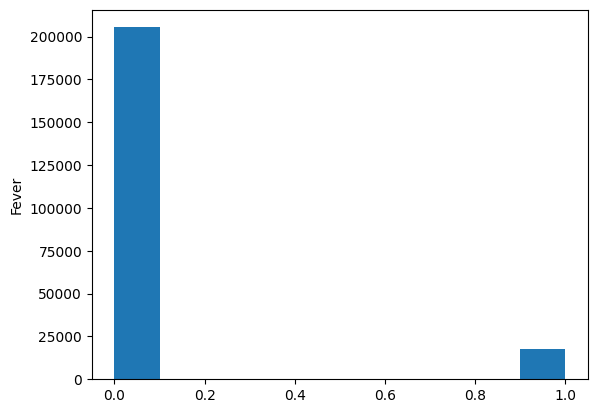

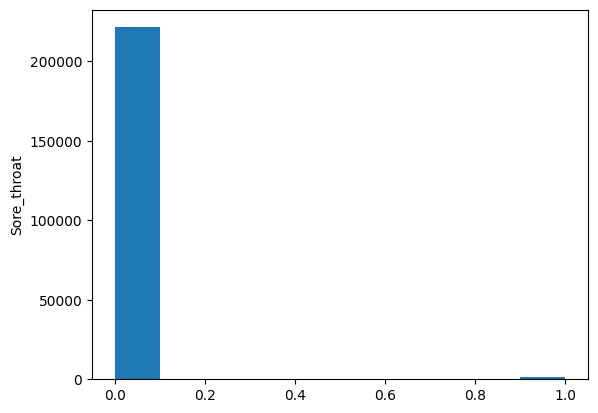

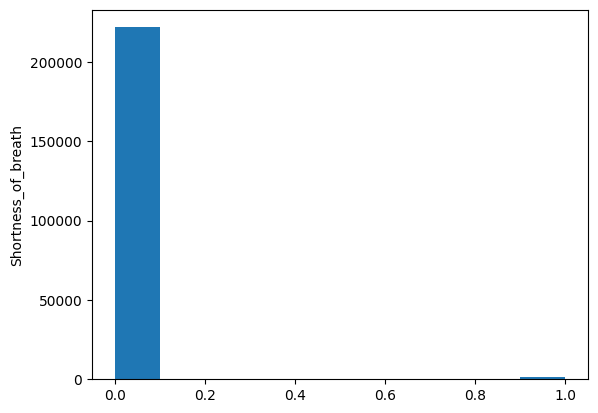

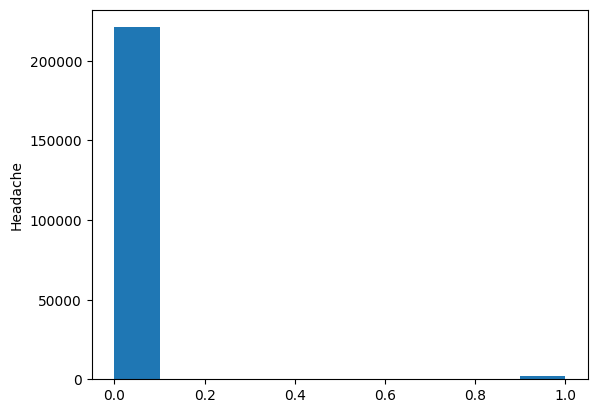

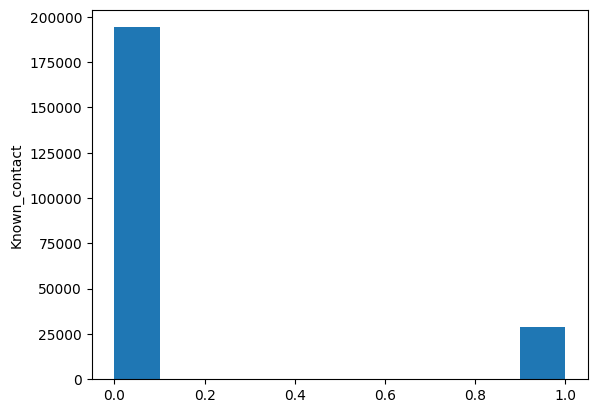

In [31]:
for predictor in X_train.columns[1:]:
    plt.hist(X_train[predictor])
    plt.ylabel(predictor)
    plt.show()

It is obvous that we need to normalize.
Everything is leaning towards 0.

In [32]:
X_train.mean()

Cough_symptoms         0.152427
Fever                  0.078870
Sore_throat            0.006948
Shortness_of_breath    0.005707
Headache               0.008746
Known_contact          0.129265
dtype: float64

In [33]:
X_train.std()

Cough_symptoms         0.359435
Fever                  0.269536
Sore_throat            0.083066
Shortness_of_breath    0.075326
Headache               0.093110
Known_contact          0.335494
dtype: float64

In [34]:
normalized_df = X_train.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
normalized_df.head()

,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
207362,-0.424074,-0.292613,-0.083647,-0.075758,-0.093931,-0.385297
194146,2.358068,-0.292613,-0.083647,-0.075758,-0.093931,-0.385297
33735,-0.424074,-0.292613,-0.083647,-0.075758,-0.093931,-0.385297
38887,2.358068,3.417470,-0.083647,-0.075758,-0.093931,2.595386
40726,-0.424074,-0.292613,-0.083647,-0.075758,-0.093931,-0.385297


#### Questions:
- Why did we use only the training data to obtain mean and std?

### Step 6: Review the dimensions of training & validation set
**Also preview some of the "input features" and "correct labels" for the datasets**

In [35]:
X_train.shape

(223077, 6)

In [36]:
X_test.shape

(55770, 6)

### Step 7: Create a machine learning model
#### Questions to think about
- what the data is saying?
- what kind of model(learning agent) is suited for the data?
- are all predictors necessary for the agent?

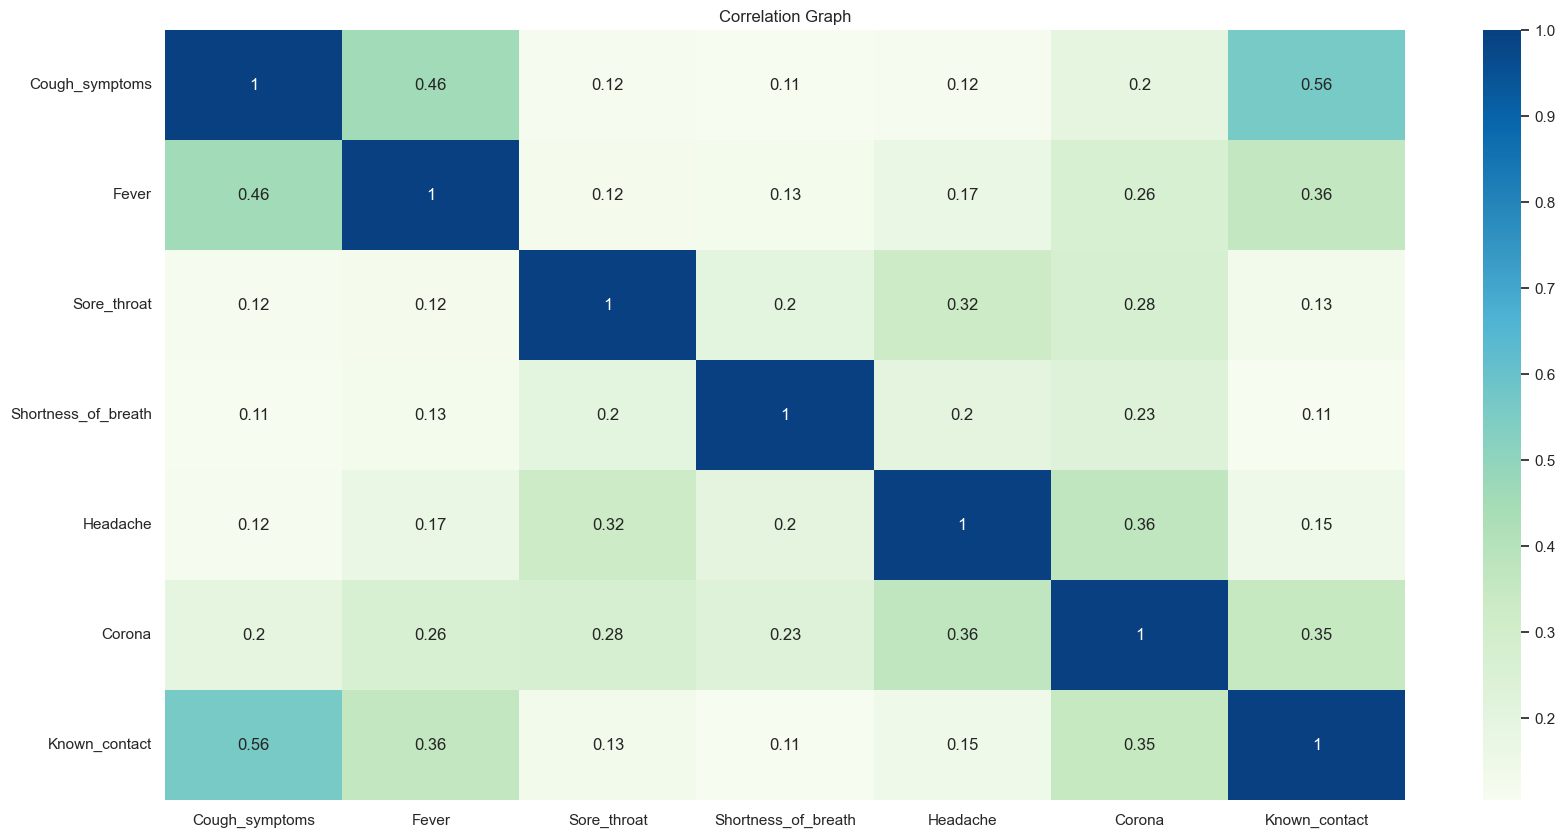

In [37]:
sns.set()
plt.figure(figsize = (20,10))
sns.heatmap(corona_df.corr(), cmap='GnBu', annot=True)
plt.title('Correlation Graph')
plt.show()

<Axes: >

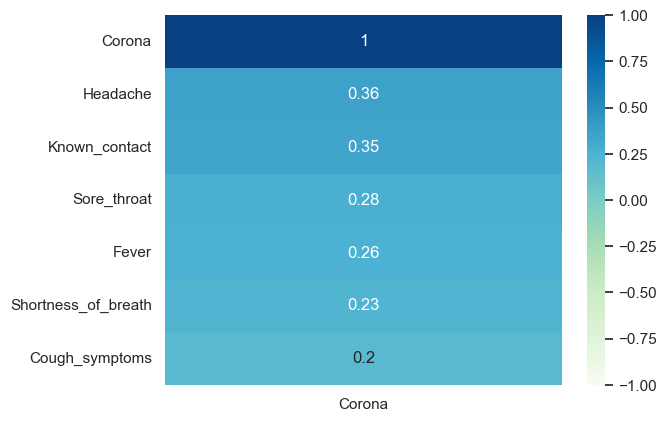

In [41]:
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.heatmap(corona_df.corr()[['Corona']].sort_values(by='Corona', ascending=False), vmin=-1, vmax=1, annot=True, cmap='GnBu')

### Step 8: Train the model

In [43]:
# we could just train the data with the lines imput here but we want to make sure our data is good for our model.
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

### Step 9: Evaluate the model on the training data

### Step 10: Evaluate on validation set

### Step 11: Check what what the model actually predicts

### Step 12: Is 'accuracy' sufficient to evaluate our agent?

### Step 13: How can the performance be improved?